In [1]:
import argparse

import torch
import torch.nn.functional as F
# torch_version = str(torch.__version__)
# scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
# sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
# !pip install torch-scatter -f $scatter_src
# !pip install torch-sparse -f $sparse_src
# !pip install torch-geometric
# !pip install ogb
import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv
import pickle
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator


In [2]:
DATASET = 'ogbn-arxiv'
DATA_ROOT = "/nlp/scr/ananjan/graph_datasets/"
NUM_EPOCHS = 2000

In [3]:
device = f'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

dataset = PygNodePropPredDataset(name=DATASET,
                                  transform=T.Compose([T.ToUndirected(), T.ToSparseTensor()]), root=DATA_ROOT)

data = dataset[0]
# data.adj_t = data.adj_t.to_symmetric()
data = data.to(device)

In [4]:
split_idx = dataset.get_idx_split()
train_idx = split_idx['train'].to(device)

In [31]:
! ls /nlp/scr/ananjan/graph_embeddings/finetuned/

bert_arxiv.pkl		minilm_arxiv.pkl	 roberta_arxiv.pkl
bert_logits_arxiv.pkl	minilm_logits_arxiv.pkl  roberta_logits_arxiv.pkl
bert_trained_arxiv.pkl	mpnet_arxiv.pkl		 roberta_trained_arxiv.pkl


In [6]:
# # from google.colab import drive
# # drive.mount("/content/drive/")
# import pickle
# from sklearn.decomposition import PCA

# embs = pickle.load(open("/nlp/scr/ananjan/graph_embeddings/finetuned/roberta_arxiv.pkl", "rb"))
# # pca = PCA(n_components=128)
# # embs = pca.fit_transform(embs)
# # embs = torch.nn.functional.normalize(torch.tensor(embs).to(device), dim=-1)
# embs = torch.tensor(embs).to(device)
# data.x = embs

In [41]:
model = torch_geometric.nn.models.GAT(data.x.shape[1], 256, num_layers=3, out_channels=dataset.num_classes, dropout=0.5).to(device)

In [42]:
def train(model, data, train_idx, optimizer):
    model.train()

    optimizer.zero_grad()
    out = model(data.x, data.adj_t)[train_idx]
    loss = F.cross_entropy(out, data.y.squeeze(1)[train_idx])
    loss.backward()
    optimizer.step()

    return loss.item()


@torch.no_grad()
def test(model, data, split_idx, evaluator):
    model.eval()

    out = model(data.x, data.adj_t)
    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    return train_acc, valid_acc, test_acc

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 4000)
evaluator = Evaluator(name='ogbn-arxiv')
test_accs = []
for epoch in range(NUM_EPOCHS):
    loss = train(model, data, train_idx, optimizer)
    result = test(model, data, split_idx, evaluator)
    train_acc, valid_acc, test_acc = result
    test_accs.append(test_acc)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')
print(max(test_accs))

Epoch: 00, Loss: 3.7078, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 01, Loss: 3.3963, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 02, Loss: 3.3641, Train: 25.37%, Valid: 28.74% Test: 25.79%
Epoch: 03, Loss: 3.1974, Train: 18.01%, Valid: 25.44% Test: 23.16%
Epoch: 04, Loss: 3.1898, Train: 28.96%, Valid: 30.90% Test: 27.62%
Epoch: 05, Loss: 3.1352, Train: 27.33%, Valid: 29.73% Test: 26.81%
Epoch: 06, Loss: 3.0536, Train: 24.01%, Valid: 22.00% Test: 20.01%
Epoch: 07, Loss: 2.9939, Train: 26.75%, Valid: 28.90% Test: 26.33%
Epoch: 08, Loss: 2.9334, Train: 28.71%, Valid: 30.47% Test: 27.30%
Epoch: 09, Loss: 2.8483, Train: 31.52%, Valid: 31.98% Test: 28.63%
Epoch: 10, Loss: 2.7788, Train: 37.54%, Valid: 35.56% Test: 31.81%
Epoch: 11, Loss: 2.7022, Train: 40.22%, Valid: 37.69% Test: 33.72%
Epoch: 12, Loss: 2.6177, Train: 39.79%, Valid: 37.36% Test: 33.98%
Epoch: 13, Loss: 2.5593, Train: 41.35%, Valid: 38.62% Test: 35.12%
Epoch: 14, Loss: 2.4998, Train: 44.61%, Valid: 42.28% Test: 38.99%

Epoch: 123, Loss: 1.4909, Train: 69.12%, Valid: 68.87% Test: 68.18%
Epoch: 124, Loss: 1.4886, Train: 69.08%, Valid: 69.07% Test: 68.22%
Epoch: 125, Loss: 1.4866, Train: 69.09%, Valid: 69.07% Test: 68.38%
Epoch: 126, Loss: 1.4874, Train: 69.18%, Valid: 69.33% Test: 68.72%
Epoch: 127, Loss: 1.4847, Train: 69.34%, Valid: 69.19% Test: 68.31%
Epoch: 128, Loss: 1.4847, Train: 69.29%, Valid: 69.01% Test: 68.35%
Epoch: 129, Loss: 1.4810, Train: 69.31%, Valid: 69.21% Test: 68.66%
Epoch: 130, Loss: 1.4866, Train: 69.35%, Valid: 69.31% Test: 68.43%
Epoch: 131, Loss: 1.4796, Train: 69.35%, Valid: 69.33% Test: 68.57%
Epoch: 132, Loss: 1.4748, Train: 69.36%, Valid: 69.15% Test: 68.20%
Epoch: 133, Loss: 1.4814, Train: 69.40%, Valid: 69.34% Test: 68.51%
Epoch: 134, Loss: 1.4779, Train: 69.48%, Valid: 69.50% Test: 68.86%
Epoch: 135, Loss: 1.4768, Train: 69.52%, Valid: 69.38% Test: 68.74%
Epoch: 136, Loss: 1.4706, Train: 69.47%, Valid: 69.38% Test: 68.48%
Epoch: 137, Loss: 1.4705, Train: 69.49%, Valid: 

Epoch: 244, Loss: 1.3928, Train: 71.29%, Valid: 70.62% Test: 69.70%
Epoch: 245, Loss: 1.3975, Train: 71.24%, Valid: 70.67% Test: 69.94%
Epoch: 246, Loss: 1.3888, Train: 71.22%, Valid: 70.67% Test: 70.18%
Epoch: 247, Loss: 1.3944, Train: 71.29%, Valid: 70.21% Test: 69.27%
Epoch: 248, Loss: 1.3936, Train: 71.25%, Valid: 70.82% Test: 70.15%
Epoch: 249, Loss: 1.3875, Train: 71.29%, Valid: 70.62% Test: 69.79%
Epoch: 250, Loss: 1.3875, Train: 71.26%, Valid: 70.44% Test: 69.42%
Epoch: 251, Loss: 1.3890, Train: 71.21%, Valid: 70.71% Test: 70.18%
Epoch: 252, Loss: 1.3873, Train: 71.35%, Valid: 70.52% Test: 69.72%
Epoch: 253, Loss: 1.3973, Train: 71.33%, Valid: 70.67% Test: 69.75%
Epoch: 254, Loss: 1.3904, Train: 71.27%, Valid: 70.68% Test: 70.02%
Epoch: 255, Loss: 1.3847, Train: 71.31%, Valid: 70.36% Test: 69.35%
Epoch: 256, Loss: 1.3912, Train: 71.36%, Valid: 70.78% Test: 69.99%
Epoch: 257, Loss: 1.3814, Train: 71.31%, Valid: 70.84% Test: 70.08%
Epoch: 258, Loss: 1.3884, Train: 71.39%, Valid: 

Epoch: 365, Loss: 1.3539, Train: 72.03%, Valid: 71.33% Test: 70.57%
Epoch: 366, Loss: 1.3476, Train: 72.13%, Valid: 70.81% Test: 69.71%
Epoch: 367, Loss: 1.3443, Train: 72.05%, Valid: 71.20% Test: 70.45%
Epoch: 368, Loss: 1.3503, Train: 72.09%, Valid: 71.22% Test: 70.51%
Epoch: 369, Loss: 1.3519, Train: 72.12%, Valid: 71.10% Test: 70.30%
Epoch: 370, Loss: 1.3481, Train: 72.01%, Valid: 71.20% Test: 70.35%
Epoch: 371, Loss: 1.3474, Train: 72.13%, Valid: 71.16% Test: 70.26%
Epoch: 372, Loss: 1.3456, Train: 72.14%, Valid: 71.21% Test: 70.31%
Epoch: 373, Loss: 1.3512, Train: 72.19%, Valid: 71.33% Test: 70.54%
Epoch: 374, Loss: 1.3465, Train: 72.13%, Valid: 71.25% Test: 70.35%
Epoch: 375, Loss: 1.3444, Train: 72.13%, Valid: 71.19% Test: 70.25%
Epoch: 376, Loss: 1.3456, Train: 72.04%, Valid: 71.42% Test: 70.64%
Epoch: 377, Loss: 1.3470, Train: 72.05%, Valid: 71.21% Test: 70.30%
Epoch: 378, Loss: 1.3451, Train: 72.13%, Valid: 71.16% Test: 70.09%
Epoch: 379, Loss: 1.3456, Train: 72.17%, Valid: 

Epoch: 486, Loss: 1.3199, Train: 72.71%, Valid: 71.54% Test: 70.60%
Epoch: 487, Loss: 1.3213, Train: 72.64%, Valid: 71.59% Test: 70.94%
Epoch: 488, Loss: 1.3201, Train: 72.67%, Valid: 71.38% Test: 70.11%
Epoch: 489, Loss: 1.3242, Train: 72.64%, Valid: 71.50% Test: 70.63%
Epoch: 490, Loss: 1.3172, Train: 72.70%, Valid: 71.64% Test: 70.72%
Epoch: 491, Loss: 1.3197, Train: 72.77%, Valid: 71.55% Test: 70.65%
Epoch: 492, Loss: 1.3297, Train: 72.76%, Valid: 71.46% Test: 70.42%
Epoch: 493, Loss: 1.3239, Train: 72.72%, Valid: 71.69% Test: 70.89%
Epoch: 494, Loss: 1.3233, Train: 72.77%, Valid: 71.59% Test: 70.54%
Epoch: 495, Loss: 1.3220, Train: 72.72%, Valid: 71.35% Test: 70.39%
Epoch: 496, Loss: 1.3221, Train: 72.71%, Valid: 71.62% Test: 70.55%
Epoch: 497, Loss: 1.3217, Train: 72.72%, Valid: 71.72% Test: 70.70%
Epoch: 498, Loss: 1.3213, Train: 72.73%, Valid: 71.62% Test: 70.47%
Epoch: 499, Loss: 1.3147, Train: 72.69%, Valid: 71.47% Test: 70.65%
Epoch: 500, Loss: 1.3189, Train: 72.71%, Valid: 

Epoch: 607, Loss: 1.3012, Train: 73.18%, Valid: 71.55% Test: 70.14%
Epoch: 608, Loss: 1.3086, Train: 73.13%, Valid: 71.90% Test: 71.03%
Epoch: 609, Loss: 1.3022, Train: 73.12%, Valid: 71.88% Test: 71.03%
Epoch: 610, Loss: 1.3049, Train: 73.20%, Valid: 71.42% Test: 69.66%
Epoch: 611, Loss: 1.3069, Train: 73.00%, Valid: 71.82% Test: 70.91%
Epoch: 612, Loss: 1.3030, Train: 73.14%, Valid: 71.83% Test: 70.80%
Epoch: 613, Loss: 1.3050, Train: 73.19%, Valid: 71.50% Test: 70.22%
Epoch: 614, Loss: 1.3058, Train: 73.09%, Valid: 71.80% Test: 70.95%
Epoch: 615, Loss: 1.3053, Train: 73.26%, Valid: 71.79% Test: 70.75%
Epoch: 616, Loss: 1.3027, Train: 73.27%, Valid: 71.72% Test: 70.62%
Epoch: 617, Loss: 1.3012, Train: 73.06%, Valid: 71.70% Test: 71.01%
Epoch: 618, Loss: 1.3055, Train: 73.24%, Valid: 71.67% Test: 70.28%
Epoch: 619, Loss: 1.3039, Train: 73.22%, Valid: 71.79% Test: 70.74%
Epoch: 620, Loss: 1.2988, Train: 73.05%, Valid: 71.75% Test: 71.01%
Epoch: 621, Loss: 1.3052, Train: 73.21%, Valid: 

Epoch: 728, Loss: 1.2915, Train: 73.52%, Valid: 71.82% Test: 70.69%
Epoch: 729, Loss: 1.2896, Train: 73.53%, Valid: 71.79% Test: 70.45%
Epoch: 730, Loss: 1.2875, Train: 73.44%, Valid: 71.90% Test: 71.07%
Epoch: 731, Loss: 1.2862, Train: 73.50%, Valid: 72.15% Test: 70.99%
Epoch: 732, Loss: 1.2891, Train: 73.50%, Valid: 71.81% Test: 70.54%
Epoch: 733, Loss: 1.2894, Train: 73.46%, Valid: 71.83% Test: 70.72%
Epoch: 734, Loss: 1.2906, Train: 73.48%, Valid: 71.86% Test: 70.82%
Epoch: 735, Loss: 1.2882, Train: 73.46%, Valid: 71.96% Test: 70.66%
Epoch: 736, Loss: 1.2954, Train: 73.54%, Valid: 72.04% Test: 70.93%
Epoch: 737, Loss: 1.2905, Train: 73.48%, Valid: 71.97% Test: 71.04%
Epoch: 738, Loss: 1.2859, Train: 73.50%, Valid: 71.93% Test: 70.84%
Epoch: 739, Loss: 1.2940, Train: 73.48%, Valid: 71.94% Test: 70.79%
Epoch: 740, Loss: 1.2919, Train: 73.42%, Valid: 71.99% Test: 71.16%
Epoch: 741, Loss: 1.2883, Train: 73.51%, Valid: 72.01% Test: 70.94%
Epoch: 742, Loss: 1.2915, Train: 73.50%, Valid: 

Epoch: 849, Loss: 1.2827, Train: 73.90%, Valid: 71.95% Test: 70.32%
Epoch: 850, Loss: 1.2901, Train: 73.80%, Valid: 72.11% Test: 71.30%
Epoch: 851, Loss: 1.2799, Train: 73.81%, Valid: 72.13% Test: 71.12%
Epoch: 852, Loss: 1.2795, Train: 73.91%, Valid: 72.07% Test: 70.55%
Epoch: 853, Loss: 1.2875, Train: 73.80%, Valid: 72.14% Test: 71.27%
Epoch: 854, Loss: 1.2881, Train: 73.74%, Valid: 72.13% Test: 71.14%
Epoch: 855, Loss: 1.2834, Train: 73.83%, Valid: 71.93% Test: 70.45%
Epoch: 856, Loss: 1.2885, Train: 73.78%, Valid: 72.10% Test: 70.85%
Epoch: 857, Loss: 1.2792, Train: 73.78%, Valid: 72.12% Test: 71.08%
Epoch: 858, Loss: 1.2807, Train: 73.82%, Valid: 72.01% Test: 70.72%
Epoch: 859, Loss: 1.2828, Train: 73.80%, Valid: 72.12% Test: 71.04%
Epoch: 860, Loss: 1.2797, Train: 73.79%, Valid: 72.18% Test: 71.26%
Epoch: 861, Loss: 1.2855, Train: 73.89%, Valid: 72.00% Test: 70.56%
Epoch: 862, Loss: 1.2850, Train: 73.83%, Valid: 72.17% Test: 71.25%
Epoch: 863, Loss: 1.2885, Train: 73.75%, Valid: 

Epoch: 970, Loss: 1.2791, Train: 73.98%, Valid: 72.05% Test: 70.87%
Epoch: 971, Loss: 1.2761, Train: 73.91%, Valid: 72.18% Test: 71.17%
Epoch: 972, Loss: 1.2780, Train: 73.91%, Valid: 72.08% Test: 70.57%
Epoch: 973, Loss: 1.2806, Train: 73.99%, Valid: 72.24% Test: 70.86%
Epoch: 974, Loss: 1.2749, Train: 73.91%, Valid: 72.38% Test: 71.48%
Epoch: 975, Loss: 1.2778, Train: 74.07%, Valid: 72.25% Test: 70.94%
Epoch: 976, Loss: 1.2777, Train: 73.91%, Valid: 72.15% Test: 70.89%
Epoch: 977, Loss: 1.2785, Train: 74.02%, Valid: 72.19% Test: 70.86%
Epoch: 978, Loss: 1.2700, Train: 74.03%, Valid: 72.19% Test: 71.10%
Epoch: 979, Loss: 1.2741, Train: 74.01%, Valid: 72.33% Test: 71.19%
Epoch: 980, Loss: 1.2691, Train: 74.02%, Valid: 71.98% Test: 70.78%
Epoch: 981, Loss: 1.2768, Train: 74.07%, Valid: 72.17% Test: 71.11%
Epoch: 982, Loss: 1.2761, Train: 74.06%, Valid: 72.35% Test: 71.21%
Epoch: 983, Loss: 1.2856, Train: 74.05%, Valid: 72.02% Test: 70.44%
Epoch: 984, Loss: 1.2791, Train: 73.99%, Valid: 

Epoch: 1090, Loss: 1.2651, Train: 74.19%, Valid: 72.18% Test: 70.92%
Epoch: 1091, Loss: 1.2754, Train: 74.22%, Valid: 72.30% Test: 71.00%
Epoch: 1092, Loss: 1.2668, Train: 74.16%, Valid: 72.39% Test: 71.28%
Epoch: 1093, Loss: 1.2669, Train: 74.22%, Valid: 72.29% Test: 71.16%
Epoch: 1094, Loss: 1.2693, Train: 74.30%, Valid: 72.31% Test: 71.14%
Epoch: 1095, Loss: 1.2676, Train: 74.14%, Valid: 72.26% Test: 71.20%
Epoch: 1096, Loss: 1.2686, Train: 74.18%, Valid: 72.10% Test: 70.64%
Epoch: 1097, Loss: 1.2767, Train: 74.27%, Valid: 72.38% Test: 71.11%
Epoch: 1098, Loss: 1.2672, Train: 74.14%, Valid: 72.29% Test: 71.36%
Epoch: 1099, Loss: 1.2747, Train: 74.23%, Valid: 72.16% Test: 70.74%
Epoch: 1100, Loss: 1.2643, Train: 74.26%, Valid: 72.20% Test: 70.73%
Epoch: 1101, Loss: 1.2682, Train: 74.27%, Valid: 72.51% Test: 71.50%
Epoch: 1102, Loss: 1.2689, Train: 74.27%, Valid: 72.50% Test: 71.09%
Epoch: 1103, Loss: 1.2638, Train: 74.26%, Valid: 72.22% Test: 70.80%
Epoch: 1104, Loss: 1.2655, Train: 

Epoch: 1209, Loss: 1.2606, Train: 74.49%, Valid: 72.34% Test: 71.03%
Epoch: 1210, Loss: 1.2601, Train: 74.48%, Valid: 72.33% Test: 70.92%
Epoch: 1211, Loss: 1.2586, Train: 74.46%, Valid: 72.43% Test: 71.23%
Epoch: 1212, Loss: 1.2608, Train: 74.39%, Valid: 72.38% Test: 71.21%
Epoch: 1213, Loss: 1.2629, Train: 74.45%, Valid: 72.27% Test: 70.72%
Epoch: 1214, Loss: 1.2609, Train: 74.33%, Valid: 72.34% Test: 71.24%
Epoch: 1215, Loss: 1.2627, Train: 74.40%, Valid: 72.42% Test: 71.24%
Epoch: 1216, Loss: 1.2638, Train: 74.49%, Valid: 72.38% Test: 70.90%
Epoch: 1217, Loss: 1.2658, Train: 74.35%, Valid: 72.48% Test: 71.39%
Epoch: 1218, Loss: 1.2605, Train: 74.46%, Valid: 72.40% Test: 71.14%
Epoch: 1219, Loss: 1.2567, Train: 74.57%, Valid: 72.22% Test: 70.81%
Epoch: 1220, Loss: 1.2617, Train: 74.41%, Valid: 72.48% Test: 71.53%
Epoch: 1221, Loss: 1.2611, Train: 74.45%, Valid: 72.45% Test: 71.21%
Epoch: 1222, Loss: 1.2582, Train: 74.44%, Valid: 72.27% Test: 70.87%
Epoch: 1223, Loss: 1.2547, Train: 

Epoch: 1328, Loss: 1.2581, Train: 74.56%, Valid: 72.36% Test: 70.89%
Epoch: 1329, Loss: 1.2490, Train: 74.46%, Valid: 72.53% Test: 71.64%
Epoch: 1330, Loss: 1.2569, Train: 74.53%, Valid: 72.50% Test: 71.28%
Epoch: 1331, Loss: 1.2550, Train: 74.56%, Valid: 72.12% Test: 70.57%
Epoch: 1332, Loss: 1.2582, Train: 74.46%, Valid: 72.31% Test: 71.30%
Epoch: 1333, Loss: 1.2537, Train: 74.65%, Valid: 72.45% Test: 71.01%
Epoch: 1334, Loss: 1.2550, Train: 74.56%, Valid: 72.46% Test: 71.21%
Epoch: 1335, Loss: 1.2523, Train: 74.53%, Valid: 72.55% Test: 71.34%
Epoch: 1336, Loss: 1.2605, Train: 74.66%, Valid: 72.46% Test: 71.10%
Epoch: 1337, Loss: 1.2581, Train: 74.56%, Valid: 72.43% Test: 71.07%
Epoch: 1338, Loss: 1.2557, Train: 74.45%, Valid: 72.54% Test: 71.38%
Epoch: 1339, Loss: 1.2564, Train: 74.61%, Valid: 72.39% Test: 71.07%
Epoch: 1340, Loss: 1.2571, Train: 74.57%, Valid: 72.39% Test: 71.00%
Epoch: 1341, Loss: 1.2553, Train: 74.47%, Valid: 72.38% Test: 71.44%
Epoch: 1342, Loss: 1.2506, Train: 

Epoch: 1447, Loss: 1.2602, Train: 74.66%, Valid: 72.57% Test: 71.39%
Epoch: 1448, Loss: 1.2526, Train: 74.61%, Valid: 72.28% Test: 70.87%
Epoch: 1449, Loss: 1.2539, Train: 74.66%, Valid: 72.34% Test: 71.00%
Epoch: 1450, Loss: 1.2554, Train: 74.65%, Valid: 72.60% Test: 71.80%
Epoch: 1451, Loss: 1.2514, Train: 74.72%, Valid: 72.60% Test: 71.28%
Epoch: 1452, Loss: 1.2521, Train: 74.71%, Valid: 72.36% Test: 70.96%
Epoch: 1453, Loss: 1.2513, Train: 74.68%, Valid: 72.50% Test: 71.31%
Epoch: 1454, Loss: 1.2492, Train: 74.65%, Valid: 72.45% Test: 71.50%
Epoch: 1455, Loss: 1.2495, Train: 74.77%, Valid: 72.43% Test: 71.07%
Epoch: 1456, Loss: 1.2469, Train: 74.80%, Valid: 72.50% Test: 71.11%
Epoch: 1457, Loss: 1.2540, Train: 74.75%, Valid: 72.62% Test: 71.60%
Epoch: 1458, Loss: 1.2511, Train: 74.65%, Valid: 72.55% Test: 71.58%
Epoch: 1459, Loss: 1.2511, Train: 74.79%, Valid: 72.28% Test: 70.65%
Epoch: 1460, Loss: 1.2503, Train: 74.69%, Valid: 72.57% Test: 71.21%
Epoch: 1461, Loss: 1.2512, Train: 

Epoch: 1566, Loss: 1.2511, Train: 74.74%, Valid: 72.37% Test: 71.19%
Epoch: 1567, Loss: 1.2459, Train: 74.83%, Valid: 72.35% Test: 70.79%
Epoch: 1568, Loss: 1.2464, Train: 74.77%, Valid: 72.51% Test: 71.34%
Epoch: 1569, Loss: 1.2505, Train: 74.88%, Valid: 72.52% Test: 71.31%
Epoch: 1570, Loss: 1.2456, Train: 74.87%, Valid: 72.53% Test: 71.47%
Epoch: 1571, Loss: 1.2452, Train: 74.83%, Valid: 72.52% Test: 71.41%
Epoch: 1572, Loss: 1.2445, Train: 74.89%, Valid: 72.43% Test: 71.14%
Epoch: 1573, Loss: 1.2484, Train: 74.86%, Valid: 72.57% Test: 71.27%
Epoch: 1574, Loss: 1.2465, Train: 74.83%, Valid: 72.56% Test: 71.29%
Epoch: 1575, Loss: 1.2448, Train: 74.89%, Valid: 72.50% Test: 71.27%
Epoch: 1576, Loss: 1.2412, Train: 74.99%, Valid: 72.43% Test: 71.06%
Epoch: 1577, Loss: 1.2483, Train: 74.90%, Valid: 72.65% Test: 71.31%
Epoch: 1578, Loss: 1.2491, Train: 74.84%, Valid: 72.50% Test: 71.27%
Epoch: 1579, Loss: 1.2530, Train: 74.95%, Valid: 72.59% Test: 71.25%
Epoch: 1580, Loss: 1.2471, Train: 

Epoch: 1685, Loss: 1.2434, Train: 74.93%, Valid: 72.40% Test: 70.99%
Epoch: 1686, Loss: 1.2433, Train: 75.01%, Valid: 72.44% Test: 71.04%
Epoch: 1687, Loss: 1.2467, Train: 74.87%, Valid: 72.56% Test: 71.58%
Epoch: 1688, Loss: 1.2481, Train: 75.00%, Valid: 72.65% Test: 71.46%
Epoch: 1689, Loss: 1.2430, Train: 75.03%, Valid: 72.58% Test: 71.17%
Epoch: 1690, Loss: 1.2428, Train: 74.95%, Valid: 72.60% Test: 71.51%
Epoch: 1691, Loss: 1.2491, Train: 75.03%, Valid: 72.61% Test: 71.32%
Epoch: 1692, Loss: 1.2463, Train: 75.07%, Valid: 72.54% Test: 71.26%
Epoch: 1693, Loss: 1.2426, Train: 74.93%, Valid: 72.60% Test: 71.58%
Epoch: 1694, Loss: 1.2450, Train: 75.01%, Valid: 72.48% Test: 71.17%
Epoch: 1695, Loss: 1.2426, Train: 74.98%, Valid: 72.63% Test: 71.24%
Epoch: 1696, Loss: 1.2351, Train: 74.96%, Valid: 72.60% Test: 71.49%
Epoch: 1697, Loss: 1.2494, Train: 75.00%, Valid: 72.53% Test: 71.45%
Epoch: 1698, Loss: 1.2437, Train: 75.01%, Valid: 72.40% Test: 71.08%
Epoch: 1699, Loss: 1.2383, Train: 

Epoch: 1804, Loss: 1.2448, Train: 75.04%, Valid: 72.64% Test: 71.65%
Epoch: 1805, Loss: 1.2386, Train: 75.11%, Valid: 72.37% Test: 71.06%
Epoch: 1806, Loss: 1.2377, Train: 75.12%, Valid: 72.61% Test: 71.33%
Epoch: 1807, Loss: 1.2409, Train: 75.12%, Valid: 72.54% Test: 71.39%
Epoch: 1808, Loss: 1.2401, Train: 75.16%, Valid: 72.47% Test: 71.06%
Epoch: 1809, Loss: 1.2382, Train: 75.10%, Valid: 72.59% Test: 71.46%
Epoch: 1810, Loss: 1.2409, Train: 74.97%, Valid: 72.54% Test: 71.50%
Epoch: 1811, Loss: 1.2389, Train: 75.04%, Valid: 72.46% Test: 71.22%
Epoch: 1812, Loss: 1.2407, Train: 75.12%, Valid: 72.43% Test: 71.09%
Epoch: 1813, Loss: 1.2411, Train: 74.95%, Valid: 72.41% Test: 71.58%
Epoch: 1814, Loss: 1.2456, Train: 75.00%, Valid: 72.52% Test: 71.40%
Epoch: 1815, Loss: 1.2340, Train: 75.10%, Valid: 72.41% Test: 71.10%
Epoch: 1816, Loss: 1.2470, Train: 75.10%, Valid: 72.63% Test: 71.58%
Epoch: 1817, Loss: 1.2436, Train: 75.13%, Valid: 72.65% Test: 71.60%
Epoch: 1818, Loss: 1.2439, Train: 

Epoch: 1923, Loss: 1.2350, Train: 75.21%, Valid: 72.73% Test: 71.31%
Epoch: 1924, Loss: 1.2403, Train: 75.16%, Valid: 72.64% Test: 71.27%
Epoch: 1925, Loss: 1.2462, Train: 75.07%, Valid: 72.55% Test: 71.35%
Epoch: 1926, Loss: 1.2427, Train: 75.15%, Valid: 72.31% Test: 70.86%
Epoch: 1927, Loss: 1.2435, Train: 75.14%, Valid: 72.69% Test: 71.62%
Epoch: 1928, Loss: 1.2397, Train: 75.11%, Valid: 72.61% Test: 71.49%
Epoch: 1929, Loss: 1.2388, Train: 75.16%, Valid: 72.29% Test: 70.69%
Epoch: 1930, Loss: 1.2344, Train: 75.09%, Valid: 72.54% Test: 71.36%
Epoch: 1931, Loss: 1.2400, Train: 75.09%, Valid: 72.56% Test: 71.58%
Epoch: 1932, Loss: 1.2392, Train: 75.20%, Valid: 72.48% Test: 70.98%
Epoch: 1933, Loss: 1.2416, Train: 75.16%, Valid: 72.69% Test: 71.53%
Epoch: 1934, Loss: 1.2394, Train: 75.17%, Valid: 72.60% Test: 71.62%
Epoch: 1935, Loss: 1.2310, Train: 75.29%, Valid: 72.48% Test: 71.06%
Epoch: 1936, Loss: 1.2376, Train: 75.22%, Valid: 72.52% Test: 71.24%
Epoch: 1937, Loss: 1.2413, Train: 

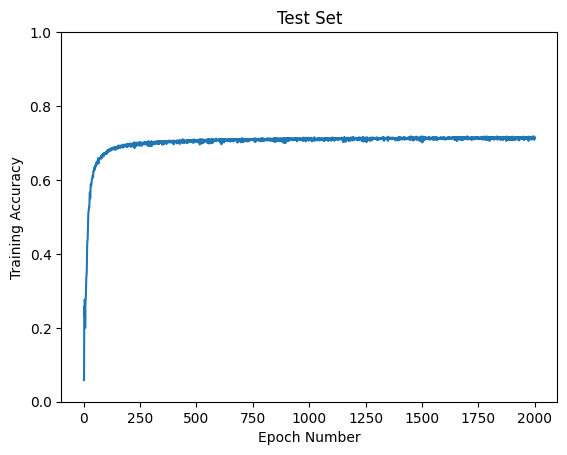

In [44]:
import matplotlib.pyplot as plt


plt.plot(range(1, NUM_EPOCHS+1), test_accs)
plt.title("Test Set")
plt.xlabel('Epoch Number')
plt.ylabel('Training Accuracy')
plt.ylim(0, 1)
plt.show()

In [47]:
# Ensemble results

final_out = model(data.x, data.adj_t)
with open("/nlp/scr/ananjan/graph_embeddings/finetuned/mpnet_logits_arxiv.pkl", 'rb') as f:
    lm_logits = pickle.load(f)
lm_logits = torch.tensor(lm_logits).to(device)

test_acc_best = -100
best_wt = -1

for rel in range(0,30):
    final_out = final_out + (rel/10)*lm_logits
    y_pred = final_out.argmax(dim=-1, keepdim=True)
    test_acc = evaluator.eval({
            'y_true': data.y[split_idx['test']],
            'y_pred': y_pred[split_idx['test']],
        })['acc']
    if (test_acc > test_acc_best):
        test_acc_best = test_acc
        best_wt = rel
        
print(best_wt/10)
print(test_acc_best)

0.4
0.7553854700327141
